# Introducing `freqopttest` 
This notebook will introduce you to `freqopttest`, a Python package for a nonparameteric, interpretable two-sample testing as described in 

    Interpretable Distribution Features with Maximum Testing Power
    Wittawat Jitkrittum, Zoltán Szabó, Kacper Chwialkowski, Arthur Gretton
    NIPS 2016.
    
The paper can be found [here](http://papers.nips.cc/paper/6148-interpretable-distribution-features-with-maximum-testing-power).
    
Before running this notebook, make sure that you have `freqopttest` included in Python's search path. See [here](https://github.com/wittawatj/interpretable-test) for how to do this.

Make sure that the following import statements do not produce any fatal error. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst
import freqopttest.glo as glo
import theano

##  Demo: ME test

A two-sample test proposes a null hypothesis $H_0: P=Q$ against an alternative hypothesis $H_1: P\neq Q$. 
As an example, let us consider a simple two-dimensional toy problem where 

$$
P(x) = \mathcal{N}(x \mid (0,0), I), 
$$

$$
Q(y) = \mathcal{N}(y \mid (m_y,0), I). 
$$

We refer to this problem as the Gaussian mean difference (GMD) problem. If $m_y=0$, then $H_0$ is true. If not, then $H_1$ holds. 

In this framework, a toy problem is represented by a `SampleSource` object (a source of two samples). Many toy problems are included in `freqopttest.data` module. Classes implementing a `SampleSource` have names starting with `SS`. Here, we will construct a `SSGaussMeanDiff` which implements the Gaussian mean difference problem. 

In [2]:
# Full sample size
n = 600

# Consider two dimensions here
dim = 2
seed = 15

# mean shift
my = 1.0
ss = data.SSGaussMeanDiff(dim, my=my)
#ss = data.SSGaussVarDiff(dim)
#ss = data.SSSameGauss(dim)
#ss = data.SSBlobs()

A `SampleSource` can be sampled to get a `TSTData` (two-sample test data) object. A `TSTData` object is just an encapsulation of two $n\times d$ numpy arrays, representing the two samples. The `TSTData` object will be fed to a testing algorithm to conduct the two-sample test. All two-sample test algorithms are implemented to take in a `TSTData` object as its input.

Let us sample from the `SampleSource` to get a `TSTData`.

In [3]:
# draw n points from P, and n points from Q. 
# tst_data is an instance of TSTData
tst_data = ss.sample(n, seed=seed)

Note that in practice, we have access to only two data matrices: X, an $(n \times d)$ matrix, and Y, an $(n \times d)$ matrix. We can also directly construct a `TSTData` with 

    tst_data = data.TSTData(X, Y)
    
Here, we sample a `TSTData` from a `SampleSource`. 


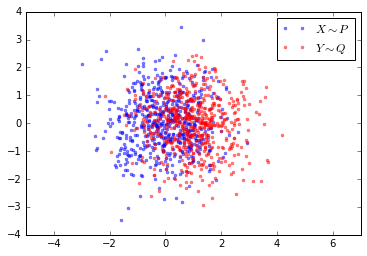

In [4]:
# Let's plot the data
x, y = tst_data.xy()
plt.plot(x[:, 0], x[:, 1], 'b.', markeredgecolor='b', label='$X\sim P$', alpha=0.5)
plt.plot(y[:, 0], y[:, 1], 'r.', markeredgecolor='r', label='$Y\sim Q$', alpha=0.5)
plt.axis('equal')
plt.legend()

Now that we have `tst_data`, let us randomly split it into two disjoint halves of equal size: `tr` and `te`. The training set `tr` will be used for parameter optimization. The testing set `te` will be used for the actual two-sample test. `tr` and `tr` are of type `TSTData`.

In [5]:
tr, te = tst_data.split_tr_te(tr_proportion=0.5, seed=2)

### Optimize the test locations (features) and the Gaussian width
We will use a Gaussian kernel for this test. Let us start by optimizing the parameters (test locations and the Gaussian width) on the training data `tr`.

In [6]:
# J = number of test locations (features)
J = 2

# significance level of the test
alpha = 0.01

In [7]:
# These are options to the optimizer. Many have default values. 
# See the code for the full list of options.
op = {
    'n_test_locs': J, # number of test locations to optimize
    'max_iter': 200, # maximum number of gradient ascent iterations
    'locs_step_size': 1.0, # step size for the test locations (features)
    'gwidth_step_size': 0.1, # step size for the Gaussian width
    'tol_fun': 1e-4, # stop if the objective does not increase more than this.
    'seed': seed+5,  # random seed
}

# optimize on the training set
test_locs, gwidth, info = tst.MeanEmbeddingTest.optimize_locs_width(tr, alpha, **op)

i:  0, lamb:  9.27, gwidth:   0.4, power: 0.5706
i:  1, lamb:  9.35, gwidth: 0.472, power: 0.5757
i:  2, lamb:  9.33, gwidth: 0.558, power: 0.5739
i:  3, lamb:  9.18, gwidth:  0.66, power: 0.5649
i:  4, lamb:  8.92, gwidth:  0.78, power: 0.5484
i:  5, lamb:  8.56, gwidth: 0.922, power: 0.5247
i:  6, lamb:  8.12, gwidth:  1.09, power: 0.4953
i:  7, lamb:  7.64, gwidth:  1.29, power: 0.4625
i:  8, lamb:  7.16, gwidth:  1.52, power: 0.4287
i:  9, lamb:   6.7, gwidth:   1.8, power: 0.3957
i: 10, lamb:  6.27, gwidth:  2.13, power: 0.3649
i: 11, lamb:  5.88, gwidth:  2.52, power: 0.3369
i: 12, lamb:  5.54, gwidth:  2.98, power: 0.3120
i: 13, lamb:  5.24, gwidth:  3.52, power: 0.2902
i: 14, lamb:  4.97, gwidth:  4.16, power: 0.2714
i: 15, lamb:  4.74, gwidth:  4.92, power: 0.2551
i: 16, lamb:  4.54, gwidth:  5.81, power: 0.2413
i: 17, lamb:  4.37, gwidth:  6.87, power: 0.2295
i: 18, lamb:  4.23, gwidth:  8.12, power: 0.2195
i: 19, lamb:   4.1, gwidth:   9.6, power: 0.2110
i: 20, lamb:     4, 

The optimization procedure returns back 3 things:

1. `test_locs`: a $J\times d$ numpy array of optimized $J$ test locations.
2. `gwidth`: optimized Gaussian width (a floating-point number)
3. `info`: a dictionary containing information gathered during the optimization e.g., test location trajectories. This is only for logging and not needed to construct a test.

## Two-sample test

From the optimization, we now have `test_locs` (optimized test locations as a $Jxd$ matrix) and `gwidth` (optimized Gaussian width). Let us use these two parameters to perform the ME test on the test data `te` (not `tr`).

In [8]:
# Construct a MeanEmbeddingTest object with the best optimized test features, 
# and optimized Gaussian width
met_opt = tst.MeanEmbeddingTest(test_locs, gwidth, alpha)

In [9]:
# Do the two-sample test on the test data te. 
# The returned test_result is a dictionary.
test_result = met_opt.perform_test(te)

In [10]:
test_result

{'alpha': 0.01,
 'h0_rejected': True,
 'pvalue': 1.2619067374726832e-34,
 'test_stat': 156.11053860197126}

Here we see that the test rejects the null hypothesis with a very small p-value.


**Exercise**: Go back to the beginning, change `my=0`, and run this notebook again. With this setting, we have that $H_0: P=Q$ is true. The test will not reject the null hypothesis.

See `ipynb/me_test.ipynb` for more ways to use the ME test. See `ipynb/smooth_cf_test.ipynb` on how to use the SCF test with optimization.

## Extra: Information from the optimization

Here we show what is contained in the `info` variable returned from the optimization.

optimized width: 7.256


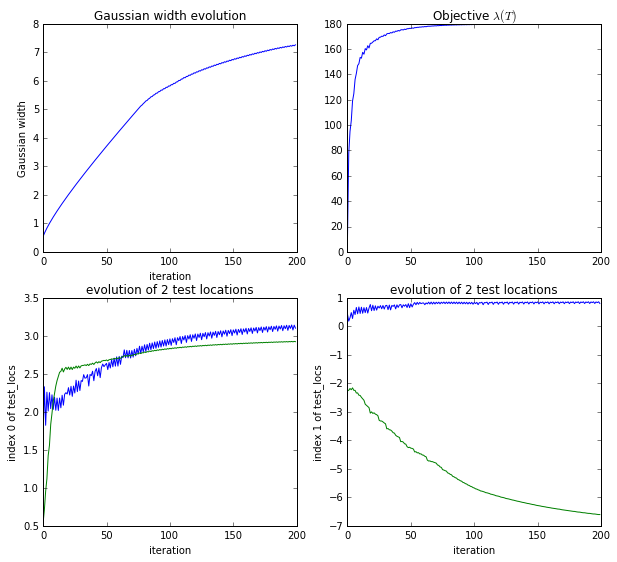

In [11]:
# Plot evolution of the test locations, Gaussian width

# trajectories of the Gaussian width
gwidths = info['gwidths']
fig, axs = plt.subplots(2, 2, figsize=(10, 9))
axs[0, 0].plot(gwidths)
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('Gaussian width')
axs[0, 0].set_title('Gaussian width evolution')

# evolution of objective values
objs = info['obj_values']
axs[0, 1].plot(objs)
axs[0, 1].set_title('Objective $\lambda(T)$')

# trajectories of the test locations
# iters x J. X Coordinates of all test locations
locs = info['test_locs']
for coord in [0, 1]:
    locs_d0 = locs[:, :, coord]
    J = locs_d0.shape[1]
    axs[1, coord].plot(locs_d0)
    axs[1, coord].set_xlabel('iteration')
    axs[1, coord].set_ylabel('index %d of test_locs'%(coord))
    axs[1, coord].set_title('evolution of %d test locations'%J)

print('optimized width: %.3f'%gwidth)